In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = 'R3'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] = 100
n_clusters = dataset_properties['n_clusters'] #= 3
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['10x73k', 'TCGA', 'coil20', 'eMNIST_balanced_letters', 'eMNIST_mnist', 'eMNIST_balanced_digits', 'Dermatology', 'Ecoil', 'Iris', 'Rings', 'Wine', 'Australian', 'Moons', 'Squeezed_Gauss', 'Gauss_Densities', 'Pendigits', 'fashionMNIST', '3DSpheres', '20_NewsGroups', 'COIL20', 'CIFAR10', 'STL10', 'R15', 'R3'])
{'batch_size': 100, 'n_clusters': 3, 'module_name': 'Datasets.Datasets', 'function_name': 'load_R3_dataloader', 'option_name': ''}
Data_Shape is: 2
Batches Number is: 15


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 2
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 1
lr = 1e-4
sil_lambda = 0.01
entr_lambda = 0.01

kmeans_initialization = True
pretrain = True
is_MLP_AE = True

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
autoencoder = autoencoder.to(device)

In [8]:
autoencoder

Autoencoder(
  (encoder_model): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=2000, bias=True)
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=2000, out_features=2, bias=True)
    (10): Tanh()
    (11): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=False)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=2, out_features=2000, b

### Pretrain Autoencoder Model

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + "/Weigths/autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))
    norm_n_pret_epochs = autoencoder.n_pret_epochs  
    autoencoder.n_pret_epochs = 1
    autoencoder.pretrain_autoencoder()
    autoencoder.n_pret_epochs = norm_n_pret_epochs

Epoch: 0, Loss: 4.147891
Epoch: 1, Loss: 1.341901
Epoch: 2, Loss: 1.039276
Epoch: 3, Loss: 0.839577
Epoch: 4, Loss: 0.597618
Epoch: 5, Loss: 0.486759
Epoch: 6, Loss: 0.680716
Epoch: 7, Loss: 0.525382
Epoch: 8, Loss: 0.440682
Epoch: 9, Loss: 0.340041
Epoch: 10, Loss: 0.320039
Epoch: 11, Loss: 0.309657
Epoch: 12, Loss: 0.305201
Epoch: 13, Loss: 0.248073
Epoch: 14, Loss: 0.351414
Epoch: 15, Loss: 0.280684
Epoch: 16, Loss: 0.275040
Epoch: 17, Loss: 0.245309
Epoch: 18, Loss: 0.247590
Epoch: 19, Loss: 0.219840
Epoch: 20, Loss: 0.350714
Epoch: 21, Loss: 0.245912
Epoch: 22, Loss: 0.253362
Epoch: 23, Loss: 0.236686
Epoch: 24, Loss: 0.215375
Epoch: 25, Loss: 0.209943
Epoch: 26, Loss: 0.200603
Epoch: 27, Loss: 0.212527
Epoch: 28, Loss: 0.271412
Epoch: 29, Loss: 0.212494
Epoch: 30, Loss: 0.206854
Epoch: 31, Loss: 0.187119
Epoch: 32, Loss: 0.229232
Epoch: 33, Loss: 0.232219
Epoch: 34, Loss: 0.218260
Epoch: 35, Loss: 0.229554
Epoch: 36, Loss: 0.279505
Epoch: 37, Loss: 0.247034
Epoch: 38, Loss: 0.181

In [10]:
# Initialize the clustering layer using k-means
if kmeans_initialization: autoencoder.kmeans_initialization(100)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


ACC: 0.79 PUR: 0.79 NMI: 0.71 ARI: 0.59


In [11]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.set_training_variables(n_epochs=10, lr=lr, sil_lambda=0.01, entr_lambda=0.00)

latent_data, labels, clustering = autoencoder.train_autoencoder()

cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 0.0594 Cl L: 0.1194 Entropy: 0.0000 SSil: 3.0556 SIL: 0.0000 ACC: 0.77 PUR: 0.77 NMI: 0.54 ARI: 0.50
Ep: 1 Rec L: 0.0444 Cl L: 0.1088 Entropy: 0.0000 SSil: 4.1208 SIL: 0.0000 ACC: 0.83 PUR: 0.83 NMI: 0.63 ARI: 0.61
Ep: 2 Rec L: 0.0524 Cl L: 0.1032 Entropy: 0.0000 SSil: 4.6849 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.71 ARI: 0.68
Ep: 3 Rec L: 0.0683 Cl L: 0.1042 Entropy: 0.0000 SSil: 4.5762 SIL: 0.0000 ACC: 0.86 PUR: 0.86 NMI: 0.71 ARI: 0.68
Ep: 4 Rec L: 0.0510 Cl L: 0.1043 Entropy: 0.0000 SSil: 4.5660 SIL: 0.0000 ACC: 0.87 PUR: 0.87 NMI: 0.71 ARI: 0.68
Ep: 5 Rec L: 0.0497 Cl L: 0.0976 Entropy: 0.0000 SSil: 5.2425 SIL: 0.0000 ACC: 0.89 PUR: 0.89 NMI: 0.77 ARI: 0.72
Ep: 6 Rec L: 0.0491 Cl L: 0.0983 Entropy: 0.0000 SSil: 5.1717 SIL: 0.0000 ACC: 0.90 PUR: 0.90 NMI: 0.77 ARI: 0.74
Ep: 7 Rec L: 0.0448 Cl L: 0.0968 Entropy: 0.0000 SSil: 5.3181 SIL: 0.0000 ACC: 0.90 PUR: 0.90 NMI: 0.76 ARI: 0.73
Ep: 8 Rec L: 0.0543 Cl L: 0.0947 Entropy: 0.0000 SSil: 5.5252 SIL: 0.0000 ACC: 0.90 PUR:

In [12]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/R3/AE/1_Eps_ld_2_out_3_bs_100_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01' already exists.


C:\Users\PAPASOFT INC\Desktop\Soft-Silhouette-IPapakostas\General_Functions.py:22: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
C:\Users\PAPASOFT INC\Desktop\Soft-Silhouette-IPapakostas\General_Functions.py:26: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Directory './Results/R3/AE/1_Eps_ld_2_out_3_bs_100_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01/Experiments/No_TSNE' created successfully.


C:\Users\PAPASOFT INC\Desktop\Soft-Silhouette-IPapakostas\Visualization.py:70: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cluster_centers[:n_clusters, 0], cluster_centers[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


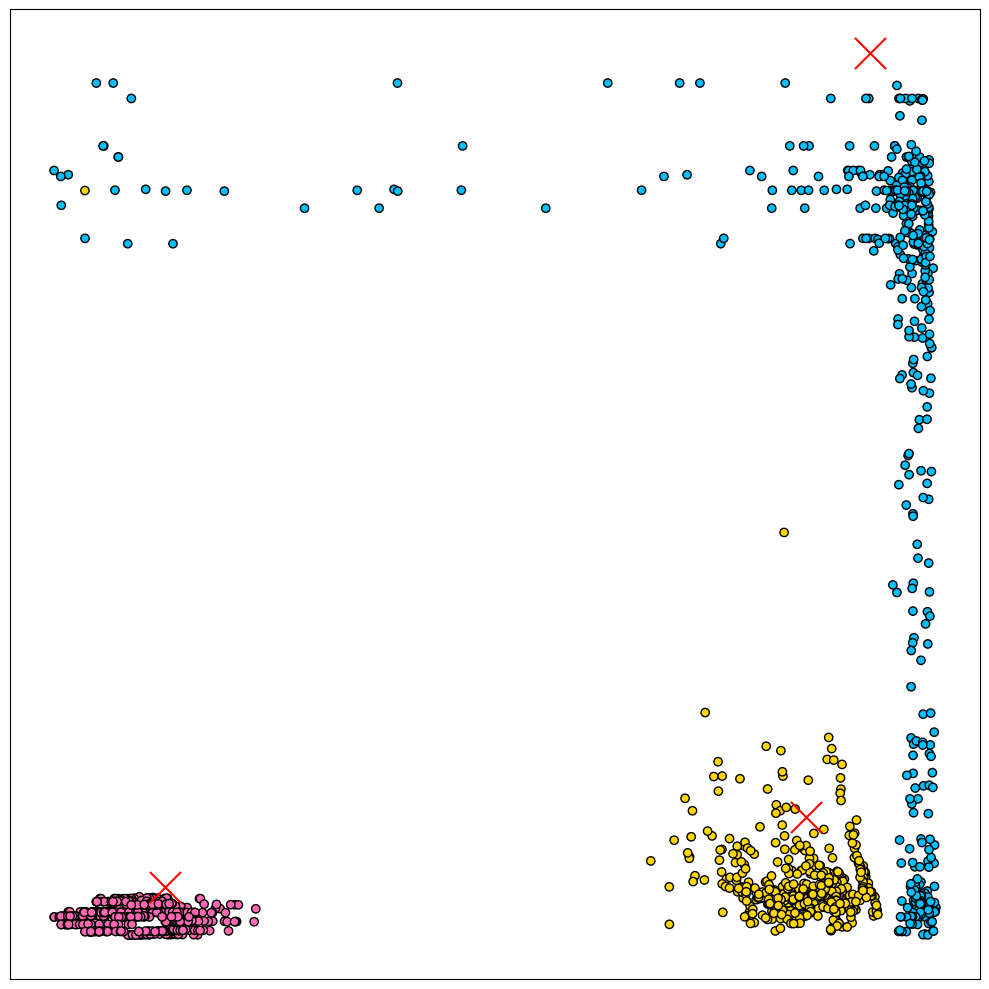

In [13]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1503 samples in 0.000s...
[t-SNE] Computed neighbors for 1503 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1503
[t-SNE] Computed conditional probabilities for sample 1503 / 1503
[t-SNE] Mean sigma: 0.025002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.322418
[t-SNE] KL divergence after 300 iterations: 0.823227
Directory './Results/R3/AE/1_Eps_ld_2_out_3_bs_100_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01/Experiments/TSNE' created successfully.


C:\Users\PAPASOFT INC\Desktop\Soft-Silhouette-IPapakostas\Visualization.py:43: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_embeddings[:n_clusters, 0], tsne_embeddings[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


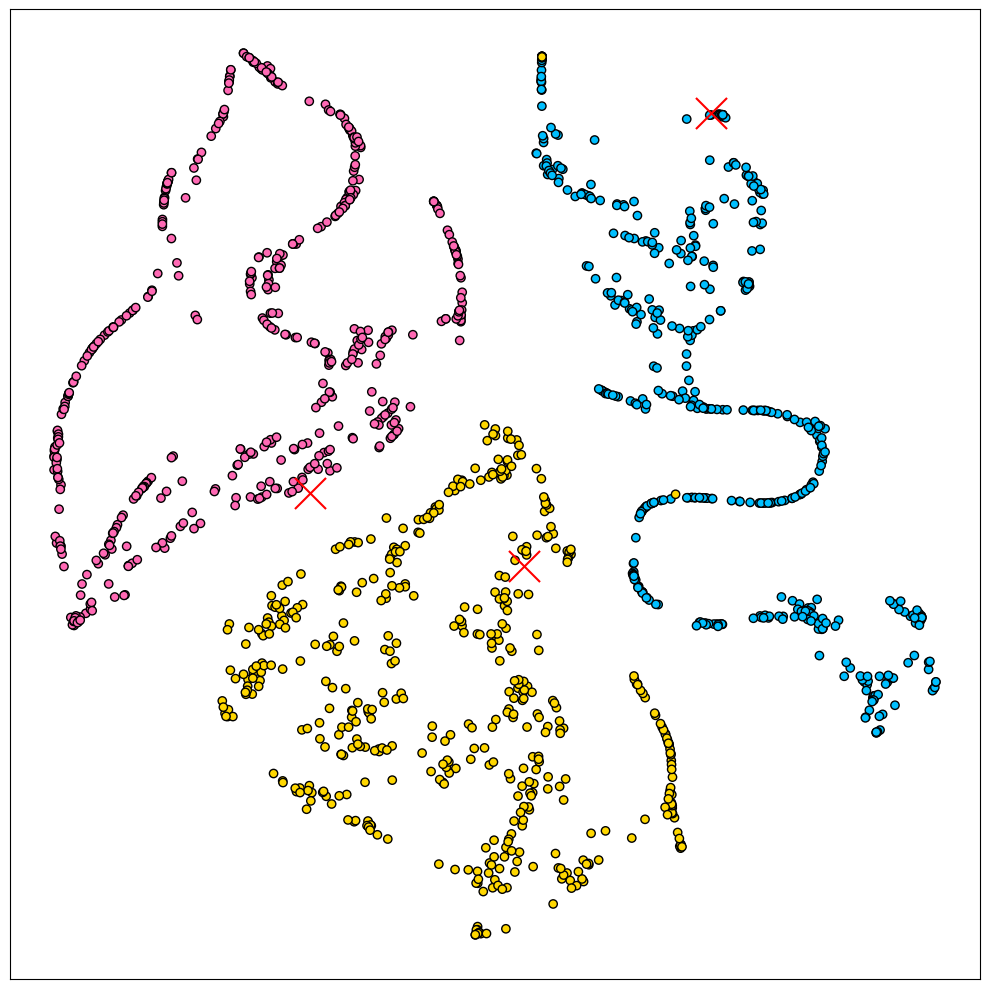

In [14]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [15]:
cluster_centers

array([[-1.2707434 , -0.537756  ],
       [ 0.6144951 , -0.2936845 ],
       [ 0.80317754,  2.365006  ]], dtype=float32)

In [16]:
clustering[0:100]

array([2, 1, 0, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 2,
       1, 2, 0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 2, 0, 0, 0, 1, 2, 1, 2, 0, 0,
       0, 1, 1, 0, 1, 1, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0,
       2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [17]:
latent_data

array([[ 0.9037113 ,  1.941534  ],
       [ 0.5458198 , -0.5355577 ],
       [-1.4115437 , -0.6222276 ],
       ...,
       [-1.4011174 , -0.6901395 ],
       [ 0.89850247,  1.5795971 ],
       [ 0.38958797, -0.54040307]], dtype=float32)

In [18]:
KMeans(n_clusters=3, init=cluster_centers).fit_predict(latent_data)[500:] == clustering[500:]

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,